## Reproductible forecasting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import jmstate
from jmstate import MultiStateJointModel
from uniformbands import get_bands

In [2]:
torch.manual_seed(0)
sigmoid = torch.jit.script(jmstate.functions.sigmoid)

@torch.jit.script
def f(gamma, x, b):
    psi = gamma + b
    psi[:, 1].exp_()
    return psi

In [3]:
lmda, k = 6, 2
gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.diag(torch.tensor([1.0, 0.1, 1.0]))
Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R = torch.tensor([[1.1]])
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)
Q_chol = torch.linalg.cholesky(Q)
R_chol = torch.linalg.cholesky(R)

alphas = {(0, 1): torch.tensor([.7])}
betas = {(0, 1): torch.tensor([-.5, .5, 1.2])}

real_params = jmstate.types.ModelParams(
    gamma,
    (jmstate.utils.flat_from_cov(Q, method="diag"), "diag"),
    (jmstate.utils.flat_from_cov(R, method="ball"), "ball"),
    alphas,
    betas
)

In [4]:
weibull_fn = jmstate.functions.weibull(k, lmda)
surv = {(0, 1): (weibull_fn, sigmoid)}
model_design = jmstate.types.ModelDesign(f, sigmoid, surv)
real_model = MultiStateJointModel(model_design, real_params, n_quad=128)

n, p = 500, 3
t = torch.linspace(0, 15, 15)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, p)

b = Q_dist.sample((n,))
psi = f(gamma, x, b)

trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = jmstate.types.SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c)


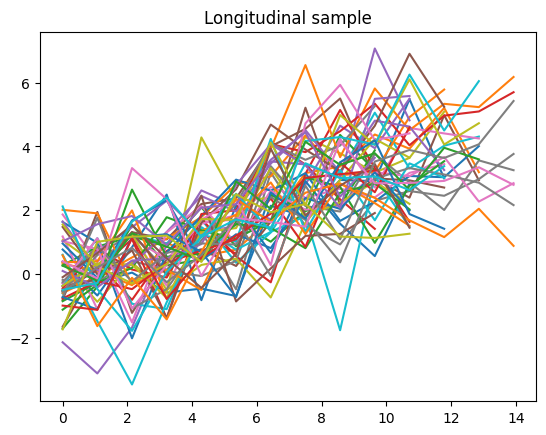

In [5]:
y = model_design.regression_fn(t, psi)
y += R_dist.sample(y.shape[:2])
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan

plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.show()

In [6]:
init_params = jmstate.types.ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(jmstate.utils.flat_from_cov(Q, method="diag")), "diag"),
    (torch.zeros_like(jmstate.utils.flat_from_cov(R, method="ball")), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = jmstate.types.ModelData(x, t, y, trajectories, c)
model = MultiStateJointModel(model_design, init_params)
model.fit(data, n_iter=3000)
model.get_metrics(
    callbacks=[jmstate.callbacks.compute_criteria, jmstate.callbacks.compute_fim]
)
std_error = model.get_stderror()
print("Fitted parameters:", model.params_)
print("Fitted metrics:", model.metrics_)
print("Standard Error:", std_error)

Running metrics loop: 100%|██████████| 1000/1000 [00:05<00:00, 181.27it/s]

Fitted parameters: ModelParams(gamma=tensor([4.0071, 0.3807, 5.8709]), Q_repr=(tensor([ 0.0384,  0.6587, -0.0302]), 'diag'), R_repr=(tensor([-0.0486]), 'ball'), alphas={(0, 1): tensor([0.7057])}, betas={(0, 1): tensor([-0.5382,  0.5219,  1.1802])})
Fitted metrics: {'loglik': tensor([-11124.4023]), 'nloglik_pen': tensor([11124.4023]), 'aic': tensor([22270.8047]), 'bic': tensor([22317.1660]), 'fim': tensor([[ 6.4818e+02, -2.9456e+02, -2.3408e+02, -6.3572e+00, -1.5415e+00,
          5.9161e+00, -4.7845e+01,  6.7484e+01,  1.7172e+01,  1.1029e+01,
         -2.6540e+01],
        [-2.9456e+02,  5.3646e+02,  3.1646e+01,  7.6082e+00,  1.2325e+01,
          9.6624e+00,  4.4490e+01, -2.5846e+01, -1.4314e+01, -6.0383e+00,
          2.6791e+01],
        [-2.3408e+02,  3.1646e+01,  2.1974e+02, -6.0597e+00,  8.3164e-01,
          2.8650e-01,  2.6982e+01, -5.6322e+01, -9.2270e+00, -6.3298e+00,
          1.7856e+01],
        [-6.3572e+00,  7.6082e+00, -6.0597e+00,  2.0205e+02, -6.5981e+00,
         -5.

In [10]:
new_params = jmstate.utils.sample_params_from_model(model, 10)
print(new_params)

[ModelParams(gamma=tensor([3.9074, 0.3486, 5.7485]), Q_repr=(tensor([ 0.0318,  0.7228, -0.1054]), 'diag'), R_repr=(tensor([-0.0355]), 'ball'), alphas={(0, 1): tensor([0.6580])}, betas={(0, 1): tensor([-0.4902,  0.6714,  1.3080])}), ModelParams(gamma=tensor([3.9535, 0.3391, 5.8087]), Q_repr=(tensor([0.0301, 0.6039, 0.1218]), 'diag'), R_repr=(tensor([-0.0272]), 'ball'), alphas={(0, 1): tensor([0.6021])}, betas={(0, 1): tensor([-0.5231,  0.3584,  0.9908])}), ModelParams(gamma=tensor([3.9577, 0.3329, 5.8538]), Q_repr=(tensor([-0.1027,  0.6693,  0.0513]), 'diag'), R_repr=(tensor([-0.0263]), 'ball'), alphas={(0, 1): tensor([0.6502])}, betas={(0, 1): tensor([-0.5752,  0.6441,  1.1292])}), ModelParams(gamma=tensor([4.0873, 0.4051, 6.0029]), Q_repr=(tensor([ 0.0024,  0.6637, -0.1001]), 'diag'), R_repr=(tensor([-0.0834]), 'ball'), alphas={(0, 1): tensor([0.6494])}, betas={(0, 1): tensor([-0.5687,  0.5819,  1.1818])}), ModelParams(gamma=tensor([4.0473, 0.4074, 5.8054]), Q_repr=(tensor([-0.0092,  

In [8]:
n_test = 100
x_test = torch.randn(n_test, p)
b_test = Q_dist.sample((n_test,))
psi_test = f(gamma, x_test, b_test)
trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]

y_test = model_design.regression_fn(t, psi_test)
y_test += R_dist.sample(y_test.shape[:2])

Predicting survival log probabilities: 100%|██████████| 1000/1000 [00:19<00:00, 52.33it/s]


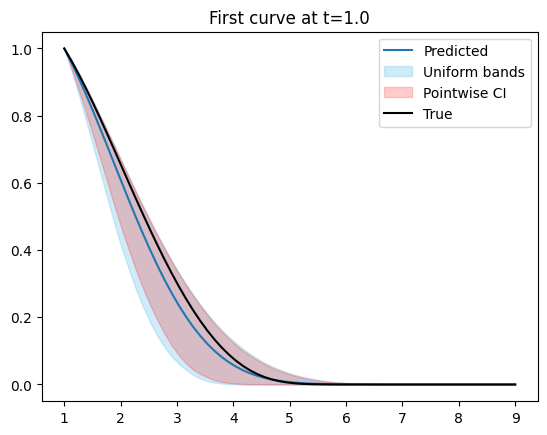

Time 1.0: Uniform coverage = 0.920, Pointwise coverage = 0.900


Predicting survival log probabilities:   0%|          | 5/1000 [00:00<00:24, 40.77it/s]


KeyboardInterrupt: 

In [11]:
prediction_times = torch.linspace(1.0, 6.0, 4)
u_grid = torch.linspace(0, 8, 64)

log_probs_true = []
for time in prediction_times:
    c_test = torch.full((n_test,), time)
    sample_test_data = jmstate.types.SampleData(x_test, trajectories_init_test, psi_test, c_test)
    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    log_probs_true.append(real_model.compute_surv_log_probs(sample_test_data, u))

uniform_coverage = []
pointwise_coverage = []

for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time)

    pred_test_data = jmstate.types.ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )

    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    log_probs_pred = real_model.predict_surv_log_probs(pred_test_data, u, n_iter_b=1000, cont_warmup=10)

    uniform_covered_count = 0
    pointwise_covered_count = 0

    for j in range(n_test):
        true_prob_j = torch.exp(log_probs_true[i][j]).numpy()
        pred_probs_j = torch.vstack([torch.exp(lp[j].detach()) for lp in log_probs_pred]).numpy()

        bands_j = get_bands(pred_probs_j)
        pointwise_j = np.quantile(pred_probs_j, [0.025, 0.975], axis=0)

        uniform_covered_count += np.all((true_prob_j >= bands_j["lower"]) & (true_prob_j <= bands_j["upper"]))
        pointwise_covered_count += np.all((true_prob_j >= pointwise_j[0]) & (true_prob_j <= pointwise_j[1]))

        # Plot first curve only
        if j == 0:
            points = time + u_grid
            plt.plot(points, pred_probs_j.mean(axis=0), label="Predicted")
            plt.fill_between(points, bands_j["lower"], bands_j["upper"], color="skyblue", alpha=0.4, label="Uniform bands")
            plt.fill_between(points, pointwise_j[0], pointwise_j[1], color="red", alpha=0.2, label="Pointwise CI")
            plt.plot(points, true_prob_j, label="True", color="black")
            plt.title(f"First curve at t={time:.1f}")
            plt.legend()
            plt.show()

    uniform_coverage.append(uniform_covered_count / n_test)
    pointwise_coverage.append(pointwise_covered_count / n_test)

    print(f"Time {time:.1f}: Uniform coverage = {uniform_coverage[-1]:.3f}, Pointwise coverage = {pointwise_coverage[-1]:.3f}")

print("\nOverall coverage:")
print(f"Uniform bands: {np.mean(uniform_coverage):.3f}")
print(f"Pointwise CI: {np.mean(pointwise_coverage):.3f}")